# Рассчётно-графическая работа №1
## Студент группы КА-03мп
## Соболь Артур

### Импортируем необходимые библиотеки

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math
import statsmodels.api as sm
from datetime import datetime
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
from scipy.signal import dlti, dlsim, unit_impulse
from scipy.linalg import norm
import typing as tp
from itertools import combinations
import numpy as np
from scipy.signal import convolve
from scipy.linalg import eig, inv

In [46]:
np.set_printoptions(precision=2)
RS = RandomState(MT19937(SeedSequence(int(datetime.now().timestamp()*1e5))))

### Сначала необходимо разработать класс, который будет иметь возможность генерировать данные, симулировать системный отклик, трансформировать данные в формы, необходимые для определённых моделей и возвращать параметры этих моделей.

In [ ]:
class LDS():
    """
    Linear Dynamical System
    -----------------------
    Generates data
    """
    def __init__(self, n_real: int, n_im: int, mode: str = 'observed'):
        """
        Constructor method
        ------------------
        :param n: size of system
        :type n: int
        """
        self.n = 2*n_im + n_real
        self.p_im = n_im
        self.p_real = n_real
        if mode not in ['control', 'observed']:
            raise ValueError('mode must be strictly `conrol` or `observed`')
        self._construct_params(mode)
    
    def _construct_params(self, mode: str) -> None:
        """
        Calculate System Parameters
        ---------------------------
        :param mode: mode of system
        """
        omega_im = [np.random.default_rng().uniform(low=0., high=np.pi/8)
                        for _ in range(self.p_im)]
        self.alpha_im = [np.random.default_rng().uniform(low=0.9, high=np.cos(omega))
                        for omega in omega_im]
        min_omega = np.argmin(omega_im) if omega_im else None
        ro_min = self.alpha_im[min_omega]/np.cos(omega_im[min_omega]) if min_omega else 0.93
        ro_real = [np.round(np.random.default_rng().uniform(low=ro_min, high=1.),4)
                        for _ in range(self.p_real)]
        ro_im = [np.round(alpha/np.cos(omega),4) for alpha, omega in zip(self.alpha_im, omega_im)]
        self.beta_im = [np.sqrt(ro**2-alpha**2) for ro, alpha in zip(ro_im, self.alpha_im)]
        self.ro = ro_real + ro_im
        self.omega = [0. for _ in range(self.p_real)] + omega_im
        self.f_s = [0. for _ in range(self.p_real)] +\
            [np.random.default_rng().uniform(low=0.5, high=1.)*np.random.default_rng().choice([-1., 1])
            for _ in range(self.p_im)]
        self.f_c = [np.random.default_rng().uniform(low=0.5, high=1.)*np.random.default_rng().choice([-1., 1])
            for _ in range(self.p_real+self.p_im)]
        if mode == 'observed':
            self.c_s = [0. for _ in range(self.p_real+self.p_im)]
            self.c_c = [1. for _ in range(self.p_real+self.p_im)]
            self.b_s = self.f_s
            self.b_c = self.f_c
        else:
            self.b_s = [0. for _ in range(self.p_real+self.p_im)]
            self.b_c = [1. for _ in range(self.p_real+self.p_im)]
            self.c_s = list(map(lambda x: -x, self.f_s))
            self.c_c = self.f_c
        
    
    def simulate(self, T: int, signal: np.ndarray) -> tp.List[float]:
        """
        Simulates system response
        -------------------------
        """
        outputs = [sum([ro**(i)*(fc*np.cos(omega*i)+fs*np.sin(omega*i)) 
                    for (ro, fc, fs, omega) in zip(self.ro, self.f_c, self.f_s, self.omega)])
                    for i in range(T+1)]
        return np.append([0.], convolve(outputs, signal))[:T]


    def transform_params(self) -> tp.List[np.ndarray]:
        """
        Trasforms System params to State-Space and ARMA params
        ------------------------------------------------------
        """
        eigv = np.append(self.ro[:self.p_real], 
                    np.array([[a+b*1j, 1j*(-b)+a] for a, b in zip(self.alpha_im, self.beta_im)]).flatten())
        indexes = range(self.n)
        ai = [(-1)**i*np.sum([np.prod(eigv[list(idxs)]) for idxs in combinations(indexes, i+1)])
                for i in indexes]
        A = np.eye(len(eigv), k=-1)
        A[:, -1] = np.array(ai[::-1]).T
        C = np.append(np.zeros(self.n-1), [1.])
        G_LHS = np.array([C@np.linalg.matrix_power(A, i) for i in range(len(A))])
        G_RHS_REAL = [np.power(np.array(self.ro[:self.p_real]), i).tolist() for i in range(self.n)]
        G_RHS_IM = [sum([np.linalg.matrix_power([[a, b], [-b, a]], i)[0].tolist()
                    for (a,b) in zip(self.alpha_im, self.beta_im)], []) 
                    for i in range(self.n)]
        T = np.linalg.solve(G_LHS, np.hstack((G_RHS_REAL, G_RHS_IM)))
        B_RHS = sum([[fc] if fs == 0. else [fc, fs] for fc, fs in zip(self.f_c, self.f_s)], [])
        B = T@B_RHS
        return A, B, C
    
    def get_statespace(self) -> tp.List[np.ndarray]:
        """
        Returns params for State-Space Form
        -----------------------------------
        """
        A, B, C = self.transform_params()
        return A, B.reshape(-1,1), C.reshape(1,-1), [[0.]]
    
    def get_arma(self) -> tp.List[np.ndarray]:
        """
        Returns params for ARMA Form
        -----------------------------------
        """
        A, B, _ = self.transform_params()
        A = np.r_[1, -A[:, -1][::-1].ravel()]
        B = np.r_[0, B[::-1]]
        return A, B


### Разработаем две вспомогательные функции для визуализирования матрицы и построения графика сигнала. 

In [21]:
def bmatrix(a: np.ndarray, name: str) -> str:
    if len(a.shape) > 2:
        raise ValueError('Only 2 dim')
        
    lines = str(np.round(a, 3)).replace('[', '').replace(']', '').splitlines()
    
    Ar = [name + r' = \begin{bmatrix}']
    Ar += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    Ar +=  [r'\end{bmatrix}']
    return '\n'.join(Ar)

def plot_signal(sig: np.ndarray, filtered: np.array) -> None:
    fig, (ax_orig, ax_filt) = plt.subplots(2, 1, sharex=True)
    ax_orig.plot(sig)
    ax_orig.set_title('Original signal')
    ax_orig.margins(0, 0.1)
    ax_filt.plot(filtered)
    
    ax_filt.set_title('Filtered output')
    ax_filt.margins(0, 0.1)
    fig.tight_layout()
    plt.show()

## Теперь зададим начальные параметры и перейдём к реализации линейной модели и её симуляции.
### NUM_REAL & NUM_COMPLEX будут отвечать за Жораднову клетку.
### Также, укажем количество исследований - K.

In [39]:
NUM_REAL = 5
NUM_COMPLEX = 1
K = 100

lds = LDS(NUM_REAL, NUM_COMPLEX)
sig = unit_impulse(K)

display(Math(bmatrix(np.array(lds.f_s), r'f^s')))
display(Math(bmatrix(np.array(lds.f_c), r'f^c')))
display(Math(bmatrix(np.array(lds.ro), r'\rho')))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Произведём симуляцию линейной модели

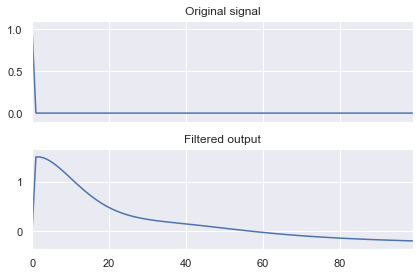

In [40]:
%matplotlib inline
sns.set()
plot_signal(sig, lds.simulate(K, sig))

### Теперь рассмотрим ситуацию с пространством состояний 

/Users/huginn/Study/Math_Prog/linear_dynamics.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  A[:, -1] = np.array(ai[::-1]).T


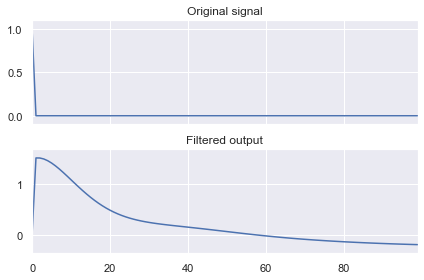

In [41]:
system = dlti(*lds.get_statespace(), dt=1)

_, y, _ = dlsim(system, sig)

%matplotlib inline
plot_signal(sig, y.T.ravel())



### Построим авторегрессионую модель ARMA и посмотрим как она будет вести с такими данными


### Импортируем необходимые библиотеки

/Users/huginn/Study/Math_Prog/linear_dynamics.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  A[:, -1] = np.array(ai[::-1]).T


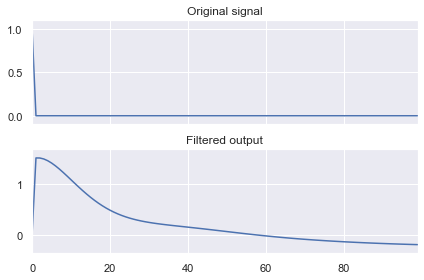

In [42]:
arma_process = sm.tsa.ArmaProcess(*lds.get_arma())

%matplotlib inline
plot_signal(sig, arma_process.impulse_response(K))

## Выводы
### По итогам проделанной работы, после моделирования и симуляции линейной модели, можно сделать вывод, что все три модели показывают идентичные результаты.